In [104]:
import os
import pickle

from glob import glob
from itertools import product

import numpy as np
import pandas as pd

from interval import interval, inf

from brb.attr_input import AttributeInput
from brb.brb import csv2BRB

# Read the Rule Base and create the Expert System

In [105]:
filename =  'csv_BenchmarkingRuleBase_v08_overall_wAP.csv_RefVals_AntImp-1Mglobscaled.csv'
filepath = os.path.join('csv_rulebases', filename)

assert os.path.exists(filepath), "rulebase doesn't exist"

# create model from rules.csv
model = csv2BRB(filepath,
                #'csv_rulebases/csv_ML_BeliefRuleBase_v5.csv_spec_refvals*ant_imp--scaled.csv',
                #'csv_rulebases/csv_HPO_BeliefRuleBase_v11.csv_spec_refvals*ant_imp--scaled.csv',
                antecedents_prefix='A_',
                consequents_prefix='D_',
                deltas_prefix='del_')

In [106]:
model.U_names

['A_Production application area',
 'A_ML task',
 'A_Detailed ML task',
 'A_Loss function',
 'A_Special properties of loss function',
 'A_Training Technique',
 'A_Machine Learning Algorithm',
 'A_Dimensionality of HPs',
 'A_Conditional HP space',
 'A_HP datatypes',
 'A_Availability of a warm-start HP configuration',
 'A_Running time per trial [s]',
 'A_Total Computing Time [s]',
 'A_Number of maximum function evaluations/ trials budget',
 'A_Obtainability of gradients',
 'A_Obtainability of good approximate',
 'A_Supports parallel evaluations',
 'A_Input Data',
 'A_#Instances training dataset',
 'A_Ratio training to test dataset',
 'A_Noise in dataset',
 'A_Hardware: Number of workers/kernels for parallel computing',
 'A_CPU / GPU',
 'A_UR: Computer operating system',
 'A_UR: quality demands',
 'A_UR: Anytime Performance',
 'A_UR: Robustness',
 "A_User's programming ability",
 'A_UR: need for model transparency',
 'A_UR: Availability of a well documented library']

In [107]:
model.U[10].referential_values

['no', 'yes']

# Max's results

In [108]:
dataset = 'turbofan'  # 'turbofan', 'scania', 'sensor', 'blisk', 'surface'
ml_task = 'Regression'  # 'Regression', 'Binary Classification', 'Multiclass Classification'
bm_base = True

file_name = 'expanded_metrics_' + dataset + '.csv'
maxr_fpath = os.path.join('max_results', file_name)

maxr = pd.read_csv(maxr_fpath, index_col=0)

maxr.columns

Index(['Trial-ID', 'HPO-library', 'HPO-method', 'ML-algorithm', 'Runs',
       'Evaluations', 'Workers', 'GPU', 'Warmstart', 'Wall clock time [s]',
       't outperform default [s]', 'Mean (final validation loss)',
       'Validation baseline', 'Area under curve (AUC)',
       'Mean (final test loss)', 'Test loss ratio (default / best)',
       'Test baseline', 'Interquartile range (final test loss)',
       't best configuration [s]', 'Generalization error',
       'Evaluations for best configuration', 'Crashes', '# training instances',
       '# training features', '# test instances', '# test features', 'dataset',
       '# cont. HPs', '# int. HPs', '# cat. HPs', 'loss_metric',
       'HPO suitability', 'Robustness',
       'UR: Availability of a well documented library',
       'UR: need for model transparency', 'UR: quality demands',
       'User's programming ability'],
      dtype='object')

In [109]:
maxr.head()

,Trial-ID,HPO-library,HPO-method,ML-algorithm,Runs,Evaluations,Workers,GPU,Warmstart,Wall clock time [s],...,# cont. HPs,# int. HPs,# cat. HPs,loss_metric,HPO suitability,Robustness,UR: Availability of a well documented library,UR: need for model transparency,UR: quality demands,User's programming ability
0,e3c90f48-3ecb-426a-94d1-769dd6794e16,robo,Bohamiann,AdaBoostRegressor,5,200.0,1,False,False,415.614018,...,1,2,1,RUL-loss,no,high,yes,yes,high,low
1,e3c90f48-3ecb-426a-94d1-769dd6794e16,robo,Bohamiann,AdaBoostRegressor,5,NaN,1,False,False,40.000000,...,1,2,1,RUL-loss,no,high,yes,yes,high,low
2,e3c90f48-3ecb-426a-94d1-769dd6794e16,robo,Bohamiann,AdaBoostRegressor,5,200.0,1,False,False,415.614018,...,1,2,1,RUL-loss,no,low,yes,yes,high,low
3,e3c90f48-3ecb-426a-94d1-769dd6794e16,robo,Bohamiann,AdaBoostRegressor,5,NaN,1,False,False,40.000000,...,1,2,1,RUL-loss,no,low,yes,yes,high,low
4,e3c90f48-3ecb-426a-94d1-769dd6794e16,robo,Bohamiann,AdaBoostRegressor,5,200.0,1,False,False,415.614018,...,1,2,1,RUL-loss,no,high,no,yes,high,low


# Input generation for the Expert System (Use Cases)

In [110]:
# Mapping between BRB and BM notation

# Map ML algorithms: BRB -> BM
# TODO: Needs to be expanded to include classification algorithms

if ml_task == 'Regression':
    
    ml_brb2bm_map = {
        'Ada Boost': 'AdaBoostRegressor',
        'Decision Tree': 'DecisionTreeRegressor',
        'Support Vector Machine': 'SVR',
        'KNN': 'KNNRegressor',
        'Gradient Boosting Machine': 'LGBMRegressor',
        'Random Forest': 'RandomForestRegressor',
        'XGBoost': 'XGBoostRegressor',
        'ElasticNet': 'ElasticNet',
        'Multilayer Perceptron': 'KerasRegressor'
    }

elif ml_task == 'Binary Classification' or ml_task == 'Multiclass Classification':

    ml_brb2bm_map = {
        'Ada Boost': 'AdaBoostClassifier',
        'Decision Tree': 'DecisionTreeClassifier',
        'Support Vector Machine': 'SVC',
        'KNN': 'KNNClassifier',
        'Gradient Boosting Machine': 'LGBMClassifier',
        'Random Forest': 'RandomForestClassifier',
        'XGBoost': 'XGBoostClassifier',
        'Logistic Regression': 'LogisticRegression',
        'Multilayer Perceptron': 'KerasClassifier',
        'Naive Bayes': 'NaiveBayes'
    }

else:
    raise Exception('Unknown ML task!')

# Map ML algorithms: BM -> BRB
ml_bm2brb_map = {v: k for k, v in ml_brb2bm_map.items()}

# Map HPO techniques: BRB -> BM
hpo_brb2bm_map = {
    'BOHAMIANN': 'Bohamiann',
    'BOHB': 'BOHB',
    'CMA-ES': 'CMA-ES',
    'FABOLAS': 'Fabolas',
    'GPBO': 'GPBO',
    'HB': 'Hyperband',
    'Random Search': 'RandomSearch',
    'SMAC': 'SMAC',
    'TPE': 'TPE',
    'Default Values': 'Default Values'
}

# Map HPO techniques: BM -> BRB
hpo_bm2brb_map = {v: k for k, v in hpo_brb2bm_map.items()}

# Map warm tart notation: BRB -> BM
wst_brb2bm_map = {'yes': True, 'no': False}

wst_bm2brb_map = {v: k for k, v in wst_brb2bm_map.items()}

# Map ML algorithms with HP data types
bmalgo2paratype_map = {
    'RandomForestRegressor': '[continuous, discrete, nominal]',
    'RandomForestClassifier': '[continuous, discrete, nominal]',
    'MLPRegressor': '[discrete, nominal]',
    'MLPClassifier': '[discrete, nominal]',
    'SVR': '[continuous, nominal]',
    'SVC': '[continuous, nominal]',
    'KerasRegressor': '[continuous, discrete, nominal]',
    'KerasClassifier': '[continuous, discrete, nominal]',
    'XGBoostClassifier': '[continuous, discrete, nominal]',
    'XGBoostRegressor': '[continuous, discrete, nominal]',
    'AdaBoostRegressor': '[continuous, discrete, nominal]',
    'AdaBoostClassifier': '[continuous, discrete, nominal]',
    'DecisionTreeRegressor': '[continuous, discrete]',
    'DecisionTreeClassifier': '[continuous, discrete]',
    'LinearRegression': '[nominal]',
    'KNNRegressor': '[discrete, nominal]',
    'KNNClassifier': '[discrete, nominal]',
    'LGBMRegressor': '[continuous, discrete]',
    'LGBMClassifier': '[continuous, discrete]',
    'LogisticRegression': '[continuous, discrete, nominal]',
    'ElasticNet': '[continuous, discrete, nominal]',
    'NaiveBayes': '[continuous]'}

# Map ML algorithms with conditional / non-conditional HPs
bmalgo2cond_map = {
    'RandomForestRegressor': 'no',
    'RandomForestClassifier': 'no',
    'MLPRegressor': 'no',
    'MLPClassifier': 'no',
    'SVR': 'no',
    'SVC': 'no',
    'KerasRegressor': 'no',
    'KerasClassifier': 'no',
    'XGBoostClassifier': 'yes',
    'XGBoostRegressor': 'yes',
    'AdaBoostRegressor': 'no',
    'AdaBoostClassifier': 'no',
    'DecisionTreeRegressor': 'no',
    'DecisionTreeClassifier': 'no',
    'LinearRegression': 'no',
    'KNNRegressor': 'no',
    'KNNClassifier': 'no',
    'LGBMRegressor': 'no',
    'LGBMClassifier': 'no',
    'LogisticRegression': 'no',
    'ElasticNet': 'no',
    'NaiveBayes': 'no'}

gpu_cpu_map = {
    False: 'CPU',
    True: 'GPU'
}

# Map dataset information with some (constant) antecedents
datset2constant_map = {
    'turbofan': {
        "Detailed ML task": 'Remaining Useful Lifetime',
        "Production application area": 'Predictive Maintenance',
        "Input Data": 'Tabular Data',
        "Ratio training to test dataset": 4,
        "ML task": 'Regression',
        "Loss function": 'customized',
        "Special properties of loss function": 'Exponential'
        },
    'scania': {
        "Detailed ML task": 'Part Failure',
        "Production application area": 'Predictive Maintenance',
        "Input Data": 'Tabular Data',
        "Ratio training to test dataset": 4,
        "ML task": 'Binary Classification',
        "Loss function": 'F1-loss', #TODO: Define loss function
        "Special properties of loss function": ''
    },
    'sensor': {
        "Detailed ML task": 'Product Quality',
        "Production application area": 'Predictive Quality',
        "Input Data": 'Tabular Data',
        "Ratio training to test dataset": 4,
        "ML task": 'Multiclass Classification',
        "Loss function": 'F1-loss', # TODO: Define loss function
        "Special properties of loss function": ''
    },
    'blisk': {
        "Detailed ML task": 'Time Series Prediction',
        "Production application area": 'Process Parameter Prediction',
        "Input Data": 'Tabular Data',
        "Ratio training to test dataset": 4,
        "ML task": 'Regression',
        "Loss function": 'Root mean squared error', # TODO: Define loss function
        "Special properties of loss function": ''
    },
    'surface': {
        "Detailed ML task": 'Image Recognition',
        "Production application area": 'Predictive Quality',
        "Input Data": 'Tabular Data',
        "Ratio training to test dataset": 4,
        "ML task": 'Binary Classification',
        "Loss function": 'F1-loss', # TODO: Define loss function
        "Special properties of loss function": ''
    }
}

In [111]:
# Create a DataFrame to store the use cases for the evaluation of the BRBES (each row corresponds to a single use case)
df_use_case = pd.DataFrame([])
df_use_case['Machine Learning Algorithm'] = maxr['ML-algorithm'].map(ml_bm2brb_map)
df_use_case['Hardware: Number of workers/kernels for parallel computing'] = maxr['Workers']
df_use_case['Availability of a warm-start HP configuration'] = maxr['Warmstart'].map(wst_bm2brb_map)
df_use_case['Number of maximum function evaluations/ trials budget'] = maxr['Evaluations']
# df_use_case['Running time per trial [s]'] = [interval[0, 30]] * len(maxr['ML-algorithm']) # TODO: Calculation necessary
df_use_case['Running time per trial [s]'] = maxr['Wall clock time [s]'] / maxr['Evaluations']
df_use_case['Total Computing Time [s]'] = maxr['Wall clock time [s]']
df_use_case['Dimensionality of HPs'] = maxr['# cont. HPs'] + maxr['# int. HPs'] + maxr['# cat. HPs']
df_use_case['HP datatypes'] = maxr['ML-algorithm'].map(bmalgo2paratype_map)
df_use_case['Conditional HP space'] = maxr['ML-algorithm'].map(bmalgo2cond_map)
df_use_case["Detailed ML task"] = datset2constant_map[dataset]["Detailed ML task"]
df_use_case["Production application area"] = datset2constant_map[dataset]["Production application area"]
df_use_case['Input Data'] = datset2constant_map[dataset]["Input Data"]
df_use_case['#Instances training dataset'] = maxr['# training instances']
df_use_case['Ratio training to test dataset'] = datset2constant_map[dataset]["Ratio training to test dataset"]
df_use_case['ML task'] = datset2constant_map[dataset]["ML task"]
df_use_case["UR: need for model transparency"] = maxr["UR: need for model transparency"]
df_use_case["UR: Availability of a well documented library"] = maxr["UR: Availability of a well documented library"]
df_use_case["User's programming ability"] = maxr["User's programming ability"]

# fixed antecedents (cannot yet be derived from the metrics .csv file)
df_use_case["UR: quality demands"] = maxr["UR: quality demands"]
df_use_case["UR: Computer operating system"] = 'Linux'
df_use_case["Obtainability of good approximate"] = [{'yes':0.5, 'no':0.5}] * len(maxr['ML-algorithm'])
df_use_case["Supports parallel evaluations"] = [{'yes':0.5, 'no':0.5}] * len(maxr['ML-algorithm'])
df_use_case["Obtainability of gradients"] = [{'yes':0.5, 'no':0.5}] * len(maxr['ML-algorithm'])
df_use_case["Noise in dataset"] = [{'yes':0.5, 'no':0.5}] * len(maxr['ML-algorithm'])
df_use_case["Training Technique"] = "Offline"


if bm_base:
    df_use_case["CPU / GPU"] = maxr['GPU'].map(gpu_cpu_map)
    df_use_case["Loss function"] = datset2constant_map[dataset]['Loss function']
    df_use_case["Special properties of loss function"] = datset2constant_map[dataset]['Special properties of loss function']
    df_use_case['UR: Anytime Performance'] = 'high'  # TODO: iterate over different AP values (in expand_metrics.py)
# 'Robustness' antecedent is not available for the current version of the rule base
# df_use_case['Robustness'] = maxr['Robustness']


In [112]:
# Columns with dict entries cause problems when identifying duplicates (not hashable)
dict_cols = {'Obtainability of good approximate', 'Supports parallel evaluations', 'Obtainability of gradients', 'Noise in dataset'}
non_dict_cols = set(df_use_case.columns) - dict_cols

# Remove duplicate use cases (Each use case is contained x times, where x is the number of HPO techniques applied on this use case)
df_use_case.drop_duplicates(subset=non_dict_cols, inplace=True, ignore_index=True)

In [113]:
df_use_case.head()

,Machine Learning Algorithm,Hardware: Number of workers/kernels for parallel computing,Availability of a warm-start HP configuration,Number of maximum function evaluations/ trials budget,Running time per trial [s],Total Computing Time [s],Dimensionality of HPs,HP datatypes,Conditional HP space,Detailed ML task,...,UR: Computer operating system,Obtainability of good approximate,Supports parallel evaluations,Obtainability of gradients,Noise in dataset,Training Technique,CPU / GPU,Loss function,Special properties of loss function,UR: Anytime Performance
0,Ada Boost,1,no,200.0,2.07807,415.614018,4,"[continuous, discrete, nominal]",no,Prediction of Remaining Useful Lifetime,...,Linux,"{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}",Offline,CPU,customized,Exponential,high
1,Ada Boost,1,no,NaN,NaN,40.000000,4,"[continuous, discrete, nominal]",no,Prediction of Remaining Useful Lifetime,...,Linux,"{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}",Offline,CPU,customized,Exponential,high
2,Ada Boost,1,no,200.0,2.07807,415.614018,4,"[continuous, discrete, nominal]",no,Prediction of Remaining Useful Lifetime,...,Linux,"{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}",Offline,CPU,customized,Exponential,high
3,Ada Boost,1,no,NaN,NaN,40.000000,4,"[continuous, discrete, nominal]",no,Prediction of Remaining Useful Lifetime,...,Linux,"{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}",Offline,CPU,customized,Exponential,high
4,Ada Boost,1,no,200.0,2.07807,415.614018,4,"[continuous, discrete, nominal]",no,Prediction of Remaining Useful Lifetime,...,Linux,"{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}","{'yes': 0.5, 'no': 0.5}",Offline,CPU,customized,Exponential,high


# Run the BRBES for the BM use cases

In [114]:
# Run the brb model for the use cases from the BM study on compute the beliefs and rankings of the HPO techniques

df_belief = pd.DataFrame([])
df_rank = pd.DataFrame([])

for idx, row in df_use_case.iterrows():
    
    use_case_dict = row.to_dict()
    use_case_dict = {'A_' + k: v for k, v in use_case_dict.items()}

    X = AttributeInput(use_case_dict)

    # run brb model
    belief_degrees = model.run(X)
    belief_degrees = {k[2:]: v for k, v in zip(model.D, belief_degrees)}

    # append results
    df_belief = df_belief.append(belief_degrees, ignore_index=True)
    
    hpo_beliefs = {v: k for k, v in belief_degrees.items()}
    hpo_beliefs = sorted(hpo_beliefs.items(), reverse=True)

    # BEWARE: THE RANK IS 0-BASED
    hpo_ranks = {hpo_belief[-1]: i for i, hpo_belief in enumerate(hpo_beliefs)}
    
    df_rank = df_rank.append(hpo_ranks, ignore_index=True)

df_use_case.to_csv('use_cases.csv')
df_belief.to_csv('hpo_beliefs.csv')
df_rank.to_csv('hpo_ranks.csv')


In [115]:
df_belief.head()

,BOHAMIANN,BOHB,CMA-ES,Default Values,FABOLAS,GPBO,HB,Random Search,SMAC,TPE
0,0.019902,0.182100,0.053067,0.144081,0.013184,0.118291,0.147494,0.082736,0.083156,0.155991
1,0.019068,0.184348,0.055928,0.140474,0.011944,0.117917,0.153529,0.081734,0.080682,0.154378
2,0.023105,0.181292,0.052281,0.143280,0.016359,0.117494,0.146692,0.081945,0.082365,0.155188
3,0.022229,0.183551,0.055152,0.139684,0.015076,0.117131,0.152737,0.080954,0.079902,0.153587
4,0.023089,0.185829,0.056365,0.129902,0.016348,0.121807,0.151108,0.069367,0.086554,0.159633


array([[<AxesSubplot:title={'center':'BOHAMIANN'}>,
        <AxesSubplot:title={'center':'BOHB'}>,
        <AxesSubplot:title={'center':'CMA-ES'}>],
       [<AxesSubplot:title={'center':'Default Values'}>,
        <AxesSubplot:title={'center':'FABOLAS'}>,
        <AxesSubplot:title={'center':'GPBO'}>],
       [<AxesSubplot:title={'center':'HB'}>,
        <AxesSubplot:title={'center':'Random Search'}>,
        <AxesSubplot:title={'center':'SMAC'}>],
       [<AxesSubplot:title={'center':'TPE'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

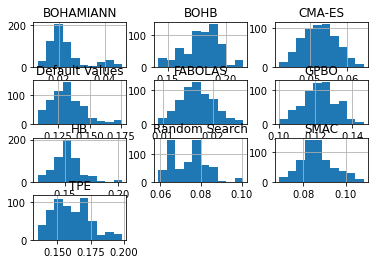

In [116]:
df_belief.hist()

<AxesSubplot:>

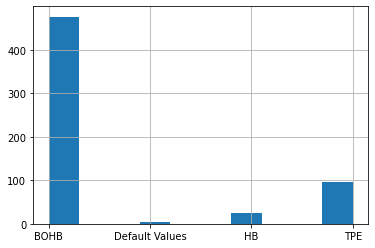

In [117]:
df_belief.idxmax(axis='columns').hist()

# Translation to max results

In [118]:
# APPROACH #1 (punish non suitable HPO techniques with a penalty of 1.0)

use_test_loss = False

brb_scores = list()  # Stores the scaled score achieved by the BRBES in each use case
rs_scores = list()  # Stores the scaled score achieved by RS in each use case
dv_scores = list()  # Stores the scaled score achieved by the Default HPs in each use case

summary_df = df_use_case.copy(deep=True)

for idx, use_case in df_use_case.iterrows():

    # Identify the experiments (from the benchmarking study), that correspond to this specific use case
    exp = maxr.loc[(maxr['ML-algorithm'] == ml_brb2bm_map[use_case['Machine Learning Algorithm']]) &
        (maxr['Workers'] == use_case['Hardware: Number of workers/kernels for parallel computing']) &
        (maxr['Warmstart'] == wst_brb2bm_map[use_case['Availability of a warm-start HP configuration']]) &
        (maxr['Wall clock time [s]'] == use_case['Total Computing Time [s]']) &
        (maxr["User's programming ability"] == use_case["User's programming ability"]) &
        (maxr['UR: need for model transparency'] == use_case['UR: need for model transparency']) &
        (maxr['UR: Availability of a well documented library'] == use_case['UR: Availability of a well documented library']) &
        (maxr['UR: quality demands'] == use_case["UR: quality demands"]) &
        (maxr['Robustness'] == 'low'), :] 
        # TODO: Specify additional antecedent values here  -> i.e. Quality Demands, Robustness

    if len(exp) == 0:
        continue
    
    # Filter HPO techniques, that have been classified as suitable for this use case based on the user requirements and the robustness antecedent
    suitable_hpos = exp.loc[exp['HPO suitability'] == 'yes', :]

    if use_test_loss:  # If available, use the test loss for the ranking of HPO techniques
    
        # Check whether the test loss is available for this experiment
        if suitable_hpos['Mean (final test loss)'].isnull().any():
            
            # If not -> rank the HPO techniques based on the validation loss
            hpos = suitable_hpos.set_index('HPO-method')['Mean (final validation loss)'] 
            hpos.loc['Default Values'] = np.nanmean(exp['Validation baseline'])

        else: 
            
            # If available -> rank the HPO techniques based on the test loss
            hpos = suitable_hpos.set_index('HPO-method')['Mean (final test loss)'] 
            hpos.loc['Default Values'] = np.nanmean(exp['Test baseline'])
    
    else:  # Always use the validation loss

        hpos = suitable_hpos.set_index('HPO-method')['Mean (final validation loss)'] 
        hpos.loc['Default Values'] = np.nanmean(exp['Validation baseline'])

    # Compute the scaled loss deviation for each suitable HPO technique in this experiment
    loss_arr = hpos.to_numpy()
    min_value = np.nanmin(loss_arr)
    max_value = np.nanmax(loss_arr[loss_arr != np.inf])
    scaled_hpos = (hpos - min_value) / (max_value - min_value)

    # Recommendation of the BRBES
    rec_hpo = df_belief.iloc[idx].idxmax(axis='columns')

    # Case 1: BRBES recommendation is not among the HPO techniques, that have been evaluated in the benchmarking study -> no distance value available
    if hpo_brb2bm_map[rec_hpo] not in exp['HPO-method'].values:
        brb_distance_value = np.nan
        rs_distance_value = np.nan
        dv_distance_value = np.nan

    # Case 2: BRBES recommendation is not suitable for this use case / experiment (i.e. not robust) -> scaled deviation = 1.0
    elif hpo_brb2bm_map[rec_hpo] not in suitable_hpos['HPO-method'].values:
        brb_distance_value = 1.0 # alternative: np.nan

        if 'RandomSearch' in scaled_hpos:
            rs_distance_value = scaled_hpos.loc['RandomSearch']
            
        else: # Random Search may also be crashed and therefore is not among the HPO techniques
            rs_distance_value = np.nan

        dv_distance_value = scaled_hpos.loc['Default Values']

    # Case 3 (default case): BRBES recommendation is among the HPO techniques of this use case / experiment -> get scaled deviation of recommendation
    else:
        brb_distance_value = scaled_hpos.loc[hpo_brb2bm_map[rec_hpo]]

        if 'RandomSearch' in scaled_hpos:
            rs_distance_value = scaled_hpos.loc['RandomSearch']
            
        else: # Random Search may also be crashed and therefore is not among the HPO techniques
            rs_distance_value = np.nan

        dv_distance_value = scaled_hpos.loc['Default Values']

    brb_scores.append(brb_distance_value)
    rs_scores.append(rs_distance_value)
    dv_scores.append(dv_distance_value)

    summary_df.loc[idx, 'BRBES Recommendation'] = hpo_brb2bm_map[rec_hpo]
    summary_df.loc[idx, 'Best HPO Technique'] = scaled_hpos.idxmin(axis=0)
    summary_df.loc[idx, 'Distance Value'] = brb_distance_value

print('BRBES avg. score (stdev): \t\t{:.3f} ({:.2f})'.format(np.nanmean(brb_scores), np.nanstd(brb_scores)))
print('RandomSearch avg. score (stdev): \t{:.3f} ({:.2f})'.format(np.nanmean(rs_scores), np.nanstd(rs_scores)))
print('Default Values avg. score (stdev): \t{:.3f} ({:.2f})'.format(np.nanmean(dv_scores), np.nanstd(dv_scores)))

if use_test_loss:
    summary_fname = "%s_max_penalty_brbes_results_val_and_test_loss.csv" % (dataset)
else:
    summary_fname = "%s_max_penalty_brbes_results_val_loss_only.csv" % (dataset)

summary_df.to_csv(os.path.join('./max_results', summary_fname))

BRBES avg. score (stdev): 		0.659 (0.46)
RandomSearch avg. score (stdev): 	0.119 (0.25)
Default Values avg. score (stdev): 	0.891 (0.30)


In [119]:
# APPROACH #2 (punish non suitable HPO techniques with scaled deviation (if suitable) + x (penalty))

use_test_loss = False

# Penalty score, that is assigned to HPO techniques, which do not meet the user requirements of a specific use case (robustness, model transparency, well documented, programming complexity)
ur_penalty = 0.05

brb_scores = list()  # Stores the scaled score achieved by the BRBES in each use case
rs_scores = list()  # Stores the scaled score achieved by RS in each use case
dv_scores = list()  # Stores the scaled score achieved by the Default HPs in each use case

summary_df = df_use_case.copy(deep=True)

for idx, use_case in df_use_case.iterrows():

    # Identify the experiments (from the benchmarking study), that correspond to this specific use case
    exp = maxr.loc[(maxr['ML-algorithm'] == ml_brb2bm_map[use_case['Machine Learning Algorithm']]) &
        (maxr['Workers'] == use_case['Hardware: Number of workers/kernels for parallel computing']) &
        (maxr['Warmstart'] == wst_brb2bm_map[use_case['Availability of a warm-start HP configuration']]) &
        (maxr['Wall clock time [s]'] == use_case['Total Computing Time [s]']) &
        (maxr["User's programming ability"] == use_case["User's programming ability"]) &
        (maxr['UR: need for model transparency'] == use_case['UR: need for model transparency']) &
        (maxr['UR: Availability of a well documented library'] == use_case['UR: Availability of a well documented library']) &
        (maxr['UR: quality demands'] == use_case["UR: quality demands"]) &
        (maxr['Robustness'] == 'low'), :] 
        # TODO: Specify additional antecedent values here  -> i.e. Quality Demands, Robustness

    if len(exp) == 0:
        continue

    if use_test_loss:  # If available, use the test loss for the ranking of HPO techniques
    
        # Check whether the test loss is available for this experiment
        if exp['Mean (final test loss)'].isnull().any():
            
            # If not -> rank the HPO techniques based on the validation loss
            hpos = exp.set_index('HPO-method')['Mean (final validation loss)'] 
            hpos.loc['Default Values'] = np.nanmean(exp['Validation baseline'])

        else: 
            
            # If available -> rank the HPO techniques based on the test loss
            hpos = exp.set_index('HPO-method')['Mean (final test loss)'] 
            hpos.loc['Default Values'] = np.nanmean(exp['Test baseline'])
    
    else:  # Always use the validation loss

        hpos = exp.set_index('HPO-method')['Mean (final validation loss)'] 
        hpos.loc['Default Values'] = np.nanmean(exp['Validation baseline'])

    # Compute the scaled loss deviation for each suitable HPO technique in this experiment
    loss_arr = hpos.to_numpy()
    min_value = np.nanmin(loss_arr)
    max_value = np.nanmax(loss_arr[loss_arr != np.inf])
    scaled_hpos = (hpos - min_value) / (max_value - min_value)

    # Filter HPO techniques, that have been classified as non suitable for this use case based on the user requirements and the robustness antecedent
    non_suitable_hpos = exp.loc[exp['HPO suitability'] == 'no', 'HPO-method'].values

    for ko_hpo in non_suitable_hpos:
        scaled_hpos[ko_hpo] += ur_penalty

    # Recommendation of the BRBES
    rec_hpo = df_belief.iloc[idx].idxmax(axis='columns')

    # Case 1: BRBES recommendation is not among the HPO techniques, that have been evaluated in the benchmarking study -> no distance value available
    if hpo_brb2bm_map[rec_hpo] not in scaled_hpos:
        brb_distance_value = np.nan
        rs_distance_value = np.nan
        dv_distance_value = np.nan

    # Case 2: BRBES recommendation is among the HPO techniques of this use case / experiment -> get scaled deviation of recommendation
    else:
        brb_distance_value = scaled_hpos.loc[hpo_brb2bm_map[rec_hpo]]

        if 'RandomSearch' in scaled_hpos:
            rs_distance_value = scaled_hpos.loc['RandomSearch']
            
        else: # Random Search may also be crashed and therefore is not among the HPO techniques
            rs_distance_value = np.nan

        dv_distance_value = scaled_hpos.loc['Default Values']

    brb_scores.append(brb_distance_value)
    rs_scores.append(rs_distance_value)
    dv_scores.append(dv_distance_value)

    summary_df.loc[idx, 'BRBES Recommendation'] = hpo_brb2bm_map[rec_hpo]
    summary_df.loc[idx, 'Best HPO Technique'] = scaled_hpos.idxmin(axis=0)
    summary_df.loc[idx, 'Distance Value'] = brb_distance_value

print('BRBES avg. score (stdev): \t\t{:.3f} ({:.2f})'.format(np.nanmean(brb_scores), np.nanstd(brb_scores)))
print('RandomSearch avg. score (stdev): \t{:.3f} ({:.2f})'.format(np.nanmean(rs_scores), np.nanstd(rs_scores)))
print('Default Values avg. score (stdev): \t{:.3f} ({:.2f})'.format(np.nanmean(dv_scores), np.nanstd(dv_scores)))

if use_test_loss:
    #summary_fname = dataset + '_brbes_results_val_and_test_loss.csv'
    summary_fname = "%s_ur_penalty_%f_brbes_results_val_and_test_loss.csv" % (dataset, round(ur_penalty, 2))
else:
    summary_fname = "%s_ur_penalty_%f_brbes_results_val_loss_only.csv" % (dataset, round(ur_penalty, 2))

summary_df.to_csv(os.path.join('./max_results', summary_fname))

BRBES avg. score (stdev): 		0.104 (0.16)
RandomSearch avg. score (stdev): 	0.164 (0.24)
Default Values avg. score (stdev): 	0.794 (0.37)
